In [6]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

# Heart Disease and Age
<img align="left" src="https://img.webmd.com/dtmcms/live/webmd/consumer_assets/site_images/article_thumbnails/slideshows/how_heart_disease_affects_your_body_slideshow/650x350_how_heart_disease_affects_your_body_slideshow.jpg" width="500"/>

## Introduction

**Background Information**

Heart disease is a broad range of diseases that affects an individual's heart and blood vessels.

These diseases can be influenced by many factors, including underlying health conditions and lifestyle choices.


**Our Question**

Can the age of an individual with heart disease be predicted by the severity of their symptoms?

**The Dataset** 

We are using the “Heart Disease” dataset. This dataset describes a range of attributes, as well as an indication as to the presence of heart disease within each individual. The specific datasets we will be analyzing contains a subset of 14 main attributes, including information about a patient’s sex, age, symptoms, and diagnosis.

https://archive.ics.uci.edu/ml/datasets/Heart+Disease

## Preliminary Exploratory Data Analysis

In [18]:
#The data can be read through the file as seen below
van_data_csv <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data",col_names =
               c("age", "sex", "chest_pain", "trestbps", "chol",
               "fbs",  "restecg", "thalach", "exang", "oldpeak", 
               "slope", "ca", "thal", "num")) %>%
                filter(restecg != "?") %>%
                filter(chol != "?") %>%
                filter(trestbps != "?")

van_data <- van_data_csv %>%
             select(age, restecg, trestbps, chol)


head(van_data)



Rows: 200 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, thalach, exang, oldpeak, slope, ca, thal
dbl (5): age, sex, chest_pain, restecg, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,restecg,trestbps,chol
<dbl>,<dbl>,<chr>,<chr>
63,1,140,260
44,1,130,209
60,1,132,218
55,1,142,228
66,2,110,213
66,1,120,0


In [19]:
van_split <- initial_split(van_data, prop = 0.75, strata = age) 
van_train <- training(van_split)  
van_test <- testing(van_split)  



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



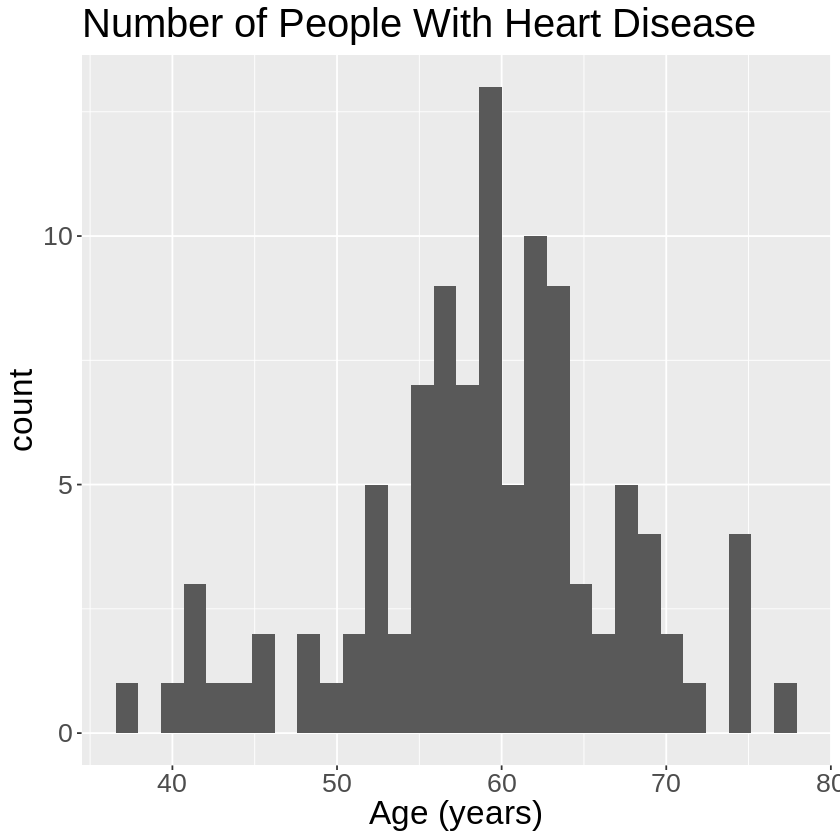

In [20]:

van_plot_hist <- ggplot(van_train, aes(x = age)) + 
            geom_histogram() + 
            labs(x = "Age (years)", title = "Number of People With Heart Disease") + 
            theme( text = element_text(size = 20)) 
van_plot_hist

Through this histogram, we can see a correlation between age, and the quantity of people that contract heart disease. The majority of those with heart disease are bewteen the ages of 55 and 65.

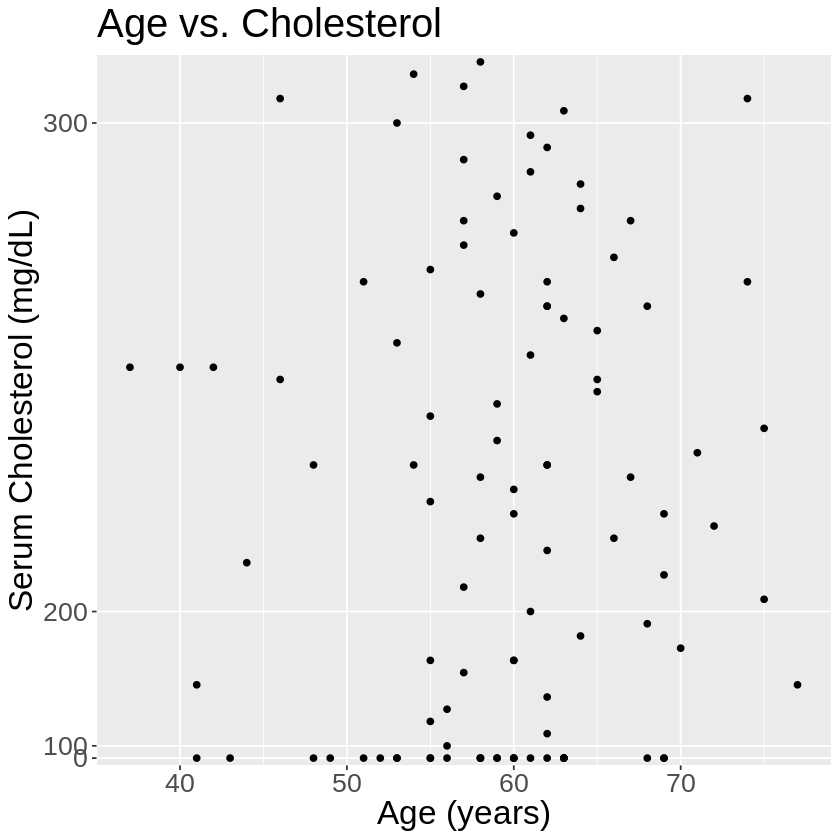

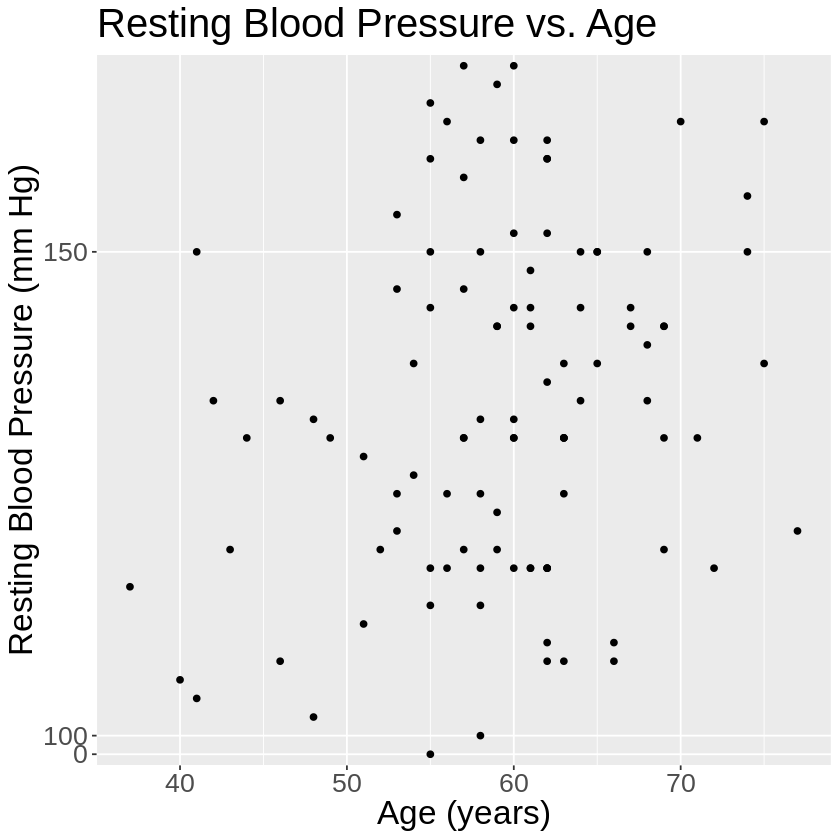

In [21]:
van_plot_chol <- ggplot(van_train, aes(x = age, y = chol)) + 
            geom_point() + 
            labs(x = "Age (years)", y = "Serum Cholesterol (mg/dL)", title = "Age vs. Cholesterol") +
            theme( text = element_text(size = 20)) +
            scale_y_discrete(breaks=c(0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500))
            
van_plot_bps <- ggplot(van_train, aes(x = age, y = trestbps)) + 
            geom_point() + 
            labs(x = "Age (years)", y = "Resting Blood Pressure (mm Hg)", title = "Resting Blood Pressure vs. Age") + 
            theme( text = element_text(size = 20)) +
            scale_y_discrete(breaks=c(0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500))        
            
van_plot_chol 

van_plot_bps 


The highest cholesterol and blood pressure levels can be seen within the older age ranges (above the age of 55).

In [22]:
van_data <- van_data %>%
        mutate(age = as_factor(age)) %>%
        mutate(chol = as.numeric(chol)) %>%
        mutate(restecg = as.numeric(restecg)) %>%
        mutate(trestbps = as.numeric(trestbps))

van_split <- initial_split(van_data, prop = 0.75 , strata = age)  
van_train <- training(van_split)   
van_test <- testing(van_split)


print("van_train")
van_train
print("van_test")
van_test

van_recipe <- recipe(age ~., data = van_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

print("van_recipe")
van_recipe

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
      set_engine("kknn") %>%
      set_mode("classification")

van_fit <- workflow() %>%
         add_recipe(van_recipe) %>%
         add_model(knn_spec) %>%
         fit(data = van_train)

Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


[1] "van_train"


age,restecg,trestbps,chol
<fct>,<dbl>,<dbl>,<dbl>
63,1,140,260
44,1,130,209
60,1,132,218
⋮,⋮,⋮,⋮
54,1,127,333
55,1,122,223
62,2,120,254


[1] "van_test"


age,restecg,trestbps,chol
<fct>,<dbl>,<dbl>,<dbl>
60,1,160,267
56,1,126,166
63,0,170,177
⋮,⋮,⋮,⋮
58,2,160,256
60,2,130,186
46,0,134,310


[1] "van_recipe"


Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [23]:
van_test_predictions <- predict(van_fit, van_test) %>%
bind_cols(van_test)

print("van_test_predictions")
van_test_predictions


van_prediction_accuracy <- van_test_predictions |>
         metrics(truth = age, estimate = .pred_class)

print("van_prediction_accuracy")
van_prediction_accuracy

[1] "van_test_predictions"


.pred_class,age,restecg,trestbps,chol
<fct>,<fct>,<dbl>,<dbl>,<dbl>
63,60,1,160,267
77,56,1,126,166
55,63,0,170,177
⋮,⋮,⋮,⋮,⋮
50,58,2,160,256
62,60,2,130,186
62,46,0,134,310


[1] "van_prediction_accuracy"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.028571429
kap,multiclass,-0.008474576


## Methods

With the following variables, we will create a KNN Classification model to predict age.
- Resting Electrocardiographic Results
- Cholesterol Levels
- Resting Blood Pressure

The KNN classification model will need to be trained, evaluated, and tuned with both training and testing sets before we are able to predict the age of a new patient. We will need to break up the data into different age groups, and compare these with each of the predictor variables. In addition, we can test our model with the other datasets provided, as they contain the same variables, but are from different locations. We will need to merge these other datasets in in order to properly complete a cross validation.

## Expected Outcome and Significance

We expect to see a positive correlation between the age of an individual, and the severity of their symptoms. As people age, they can become affected by disease and other ailments more easily. Conversely, lower age groups will experience less severe symptoms.

Understanding the relationship between age and symptoms could help medical professionals understand what to look for in a given patient. Additionally, it can help provide information as to when an individual should seek out more frequent check-ups.

The analysis could also prompt further questions:
- What are the risk factors of heart disease?
- What are early signs of heart disease in a young invdividual? In an old individual?
